## Summary of what we gonna do:   (__RULE-BASED APPROACH__)

---


  **1. Calculating the Semantic Similarity**
*   *Calculating the Semantic Vector*
*   *Calculating the cosign of the angle between the two vector*

**2. Calculating the Order Similarity**
*   *Calculating the order vector*
*   *Calculating the Normalized Difference between the two vector*

**3. Calculate the Delta Factor most optimum for :**
*   *ParaPhrase Checker*
*   *Question Similarity Checker*
*   *Semantic Similarity Checker* 

**4. Testing the accuracy of the model on some predefined DataSet as:**
*   *ParaPhrase Checker*
*   *Question Similarity Checker*
*   *Semantic Similarity Checker* 
---


**So to approach the problem statement of finding sentence similarity in short sentences, we need to consider,**
1. *Associating the words with sense.*
2. *Combining the Word sense to form a joint set for further computation.*
3. *Computing Semantic Vectors for the Sentences, which we will compare.* 
4. *Computing Order Vector for the Sentences, which we will compare.*
5. *Computing Sentence Similarity using Semantic Vector and Order Vector.*
6. *Training the model to give the most optimal result for ParaPhrase Checker, Question Similarity Checker and Semantic Similarity Checker.*
7. *Testing the accuracy of the model on some predefined Dataset.*

---



# Loading Libraries

In [1]:
!pip3 install nltk
!pip3 install numpy
import nltk
import math
import numpy as np
import re
import pprint
import csv    
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('brown')
from nltk.corpus import wordnet as wn
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
!pip3 install ipympl

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashbhaskar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yashbhaskar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yashbhaskar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/yashbhaskar/nltk_data...
[nltk_data]   Package brown is already up-to-date!




---



# 1. Associating words with a sense

In [2]:
# Input type : 2 argument with each as words
# Output type : pair of synsets for the 2 input words

def max_similarity_algo(word1, word2):
    maxPair = [None, None]
    maxSim = -1.0
    for i in wn.synsets(word1):
        for j in wn.synsets(word2):
          sim = i.path_similarity(j)
          if sim != None:
            if sim > maxSim:
              maxSim = sim
              maxPair = i, j
    return maxPair

In [3]:
print(max_similarity_algo("bvtucvjh","cat"))
print(max_similarity_algo("Bus","Car"))

[None, None]
(Synset('bus.n.04'), Synset('car.n.01'))




---



# 2. Combining the Word senset to form a joint set for further computation.

In [4]:
# Input type : It takes 2 arguments with each Sentence string
# Output type : list of words of the joint set

def joint_set(sentence_1, sentence_2):
    # words_1 = nltk.word_tokenize(sentence_1)
    # words_2 = nltk.word_tokenize(sentence_2)
    words_1 = sentence_1.split(" ")
    words_2 = sentence_2.split(" ")
    joint_words = []
    for i in words_1:
      if i not in joint_words:
        joint_words.append(i)
    for i in words_2:
      if i not in joint_words:
        joint_words.append(i)
    return joint_words

In [5]:
sen1 = 'How are you'
sen2 = 'i are fine you'
joint_set_sample = joint_set(sen1,sen2)
for i in joint_set_sample:
  print(i,end=" ")

How are you i fine 



---



# 3. Computing Semantic Vectors for the Sentences, which we will compare.

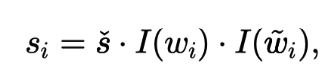

In [6]:
# Input type : 2 argument with each as words
# Output type : Words Similarity score from wordnet

def word_similarity(word1, word2):
    synsetPair = max_similarity_algo(word1, word2)
    if synsetPair == [None,None]:
      return 0.0
    return (synsetPair[0].path_similarity(synsetPair[1]))

In [7]:
# Input type : 1 argument as a word
# Output type : A score of Information Content from Brown Corpus

N = 0
brown_freqs = dict()
ThresHold = 0.2

def info_content(givenWord):
    global N
    if N == 0:
        # print("Damm")
        for sentences in brown.sents():
            for word in sentences:
                word = word.lower()
                if word not in brown_freqs:
                    brown_freqs[word] = 0
                brown_freqs[word] = brown_freqs[word] + 1
                N = N + 1
    givenWord = givenWord.lower()
    n = 0 if givenWord not in brown_freqs else brown_freqs[givenWord]
    return 1.0 - (math.log(n + 1) / math.log(N + 1))

In [8]:
# Input type : 2 argument with first as the list of words of the sentence whose semantic vector will be generated
#                              second as the list of words of the joint set
# Output type : a list of numbers representing the semantic Vector for the input sentence

def semantic_vector(words, jointSetWords):
    semantic_vec = [0] * len(jointSetWords)
    idx = 0
    for jointSetWord in jointSetWords:
        if jointSetWord in words:
            semantic_vec[idx] = 1.0
            info_val = info_content(jointSetWord)
            semantic_vec[idx] = semantic_vec[idx] * info_val * info_val
        else:
            maxSim = -1.0
            simWord = ""
            for word in words:
              sim = word_similarity(word, jointSetWord)
              if sim > maxSim:
                maxSim = sim
                simWord = word
            if maxSim > ThresHold:
              semantic_vec[idx] = maxSim 
            else:
              semantic_vec[idx] = 0.0
            semantic_vec[idx] = semantic_vec[idx] * info_content(jointSetWord) * info_content(simWord)
        idx = idx + 1
    return semantic_vec



---





# 4. Computing Order Vector for the Sentences, which we will compare.

In [9]:
# Input type : 2 argument with first as the list of words of the sentence whose semantic vector will be generated
#                              second as the list of words of the joint set
# Output type : a list of numbers representing the Word Order Vector for the input sentence

OrderThresHold = 0.4

def wordOrder_vector(words, jointSetWords):
    wordOrder_vec = [0] * len(jointSetWords)
    idx = 0
    for jointSetWord in jointSetWords:
        if jointSetWord in words:
            position = 0
            for i in words:
              position = position + 1
              if i == jointSetWord:
                break
            wordOrder_vec[idx] = position 
        else:
            maxSim = -1
            position = 0
            wordOrder_vec[idx] = 0
            for i in words:
              temp_similarity = word_similarity(i,jointSetWord)
              if(temp_similarity >= OrderThresHold):
                if(maxSim > temp_similarity):
                  maxSim = temp_similarity
                  wordOrder_vec[idx] = position 
              position = position + 1
        idx = idx + 1
    return wordOrder_vec



---



# 5. Computing Sentence Similarity using Semantic Vector and Order Vector.

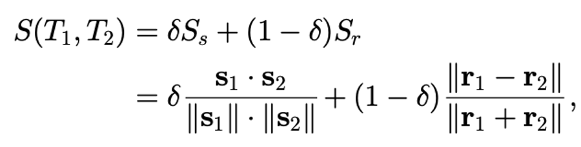

In [10]:
def similarity(sen1, sen2):
    return DELTA * semantic_similarity(sen1, sen2) + (1.0 - DELTA) * word_order_similarity(sen1, sen2)


def semantic_similarity(sen1, sen2):
    sen1 = cleaning(sen1)
    sen2 = cleaning(sen2)
    words_1 = nltk.word_tokenize(sen1)
    words_2 = nltk.word_tokenize(sen2)
    joint_words = joint_set(sen1,sen2)
    vec_1 = semantic_vector(words_1, joint_words)
    vec_2 = semantic_vector(words_2, joint_words)
    return np.dot(vec_1, vec_2) / (np.linalg.norm(vec_1) * np.linalg.norm(vec_2))


def word_order_similarity(sen1, sen2):
    words_1 = nltk.word_tokenize(sen1)
    words_2 = nltk.word_tokenize(sen2)
    joint_words = joint_set(sen1,sen2)
    r1 = wordOrder_vector(words_1, joint_words)
    r2 = wordOrder_vector(words_2, joint_words)
    diff_vec = [None] * len(joint_words)
    sum_vec = [None] * len(joint_words)
    for i in range(len(joint_words)):
      diff_vec[i] = r1[i]-r2[i]
    for i in range(len(joint_words)):
      sum_vec[i] = r1[i]+r2[i]
    if(np.linalg.norm(sum_vec) == 0):
      return 0
    ans = 1-(np.linalg.norm(diff_vec) / np.linalg.norm(sum_vec))
    return ans

## Cleaning the text for proper Computation

In [11]:
# Declaring a empty list
# in case for similarity a single sentence is broken into multiple sentences, hences i will be removing fullStops
# The same for the question mark are also what will be removed here

# Input type : String
# Output type : String

def cleaning(sen):
    cleanedSen = ""

    charCount = len(sen)

    # For full stop sentences
    for i in range(charCount):
      # For Question Mark Sentences
      if(sen[i] == '?'):
        continue

      if(sen[i] == '.'):
        # For starting . case
        if(i == 0):
          continue

        # Mr.
        if(i-2 >= 0):
          if(sen[i-1] == 'r' and sen[i-2] == 'm'):
            cleanedSen += sen[i]
            continue
        if(i-2 >= 0):
          if(sen[i-1] == 'r' and sen[i-2] == 'M'):
            cleanedSen += sen[i]
            continue
        # Mrs
        if(i-3 >= 0):
          if(sen[i-1] == 's' and sen[i-2] == 'r' and sen[i-3] == 'm'):
            cleanedSen += sen[i]
            continue
        if(i-3 >= 0):
          if(sen[i-1] == 's' and sen[i-2] == 'r' and sen[i-3] == 'M'):
            cleanedSen += sen[i]
            continue
        # For Case like N.H.P.C i.e. name of coorporation
        # U.S. , U.K. i.e. countries and places
        if(i-1 >= 0):
          if(sen[i-1].isupper()):
            cleanedSen += sen[i]
            continue
        # i.e. 
        if(i-1 >= 0 and i+2 < charCount):
          if(sen[i-1] == 'i' and sen[i+1] == 'e' and sen[i+2] == '.'):
            cleanedSen += sen[i]
            continue
        # Dr.
        if(i-2 >= 0):
          if(sen[i-1] == 'r' and sen[i-2] == 'd'):
            cleanedSen += sen[i]
            continue
        if(i-2 >= 0):
          if(sen[i-1] == 'r' and sen[i-2] == 'D'):
            cleanedSen += sen[i]
            continue
        # St.
        if(i-2 >= 0):
          if(sen[i-1] == 't' and sen[i-2] == 's'):
            cleanedSen += sen[i]
            continue
        if(i-2 >= 0):
          if(sen[i-1] == 't' and sen[i-2] == 'S'):
            cleanedSen += sen[i]
            continue
        # Jr.
        if(i-2 >= 0):
          if(sen[i-1] == 'r' and sen[i-2] == 'j'):
            cleanedSen += sen[i]
            continue
        if(i-2 >= 0):
          if(sen[i-1] == 'r' and sen[i-2] == 'J'):
            cleanedSen += sen[i]
            continue
        # Prof.
        if(i-4 >= 0):
          if(sen[i-1] == 'f' and sen[i-2] == 'o' and sen[i-3] == 'r' and sen[i-4] == 'p'):
            cleanedSen += sen[i]
            continue
        if(i-4 >= 0):
          if(sen[i-1] == 'f' and sen[i-2] == 'o' and sen[i-3] == 'r' and sen[i-4] == 'P'):
            cleanedSen += sen[i]
            continue
        # Rev.
        if(i-3 >= 0):
          if(sen[i-1] == 'v' and sen[i-2] == 'e' and sen[i-3] == 'r'):
            cleanedSen += sen[i]
            continue
        if(i-3 >= 0):
          if(sen[i-1] == 'v' and sen[i-2] == 'e' and sen[i-3] == 'R'):
            cleanedSen += sen[i]
            continue
      else:
        cleanedSen += sen[i]
    
    cleanedSen = cleanedSen.lower()
    remChar = '[\',/<\">?;:''\"\\|{}[]-=_+~!@#$%^&*()`]'
    cleanedSen2 = ""
    for i in  cleanedSen:
      if(i in remChar):
        cleanedSen2 += " "
        continue
      else:
        cleanedSen2 += i
    return cleanedSen2

In [12]:
sample_sent = "How are you? and Mr. Yash i am fine. Thank! you%%"
print(cleaning(sample_sent))

how are you and mr. yash i am fine thank  you  




---



# 6. Training the model to give the most optimal result

Sources of the dataSet
1. https://www.kaggle.com/competitions/quora-question-pairs - Question Similarity DataSet
2. https://github.com/brmson/dataset-sts/ - Semantic Similarity and ParaPhrase DataSet

## Processing the DataSet for training

In [13]:
# To be Updated
dataSet_para = [[]]
dataSet_ques = [[]]
dataSet_sem = [[]]

In [14]:
# Declaring the list storing the dataset

train_2015 = []
val_2015 = []
SICK_test_annotated = []
SICK_train = []
SICK_trial = []
msr_para_test = []
msr_para_train = []
msr_para_var = []
train_Ques = []
test_Ques = []

In [15]:
# Reading the dataset for Semantic Similarity 
f1 = open('2015.train.tsv', 'r')
for row in f1:
    temp_list = row.strip('\n').split("\t")
    if(len(temp_list) == 3):
      temp = []
      temp.append(temp_list[1])
      temp.append(temp_list[2])
      temp.append(temp_list[0])
      train_2015.append(temp)
    

f2 = open('2015.val.tsv', 'r')
for row in f2:
    temp_list = row.strip('\n').split("\t")
    if(len(temp_list) == 3):
      temp = []
      temp.append(temp_list[1])
      temp.append(temp_list[2])
      temp.append(temp_list[0])
      val_2015.append(temp)
    

f3 = open('SICK_test_annotated.txt', 'r')
for row in f3:
    temp_list = row.strip('\n').split("\t")
    if(len(temp_list) == 5):
      temp = []
      temp.append(temp_list[1])
      temp.append(temp_list[2])
      temp.append(temp_list[3])
      SICK_test_annotated.append(temp)
    

f4 = open('SICK_train.txt', 'r')
for row in f4:
    temp_list = row.strip('\n').split("\t")
    if(len(temp_list) == 5):
      temp = []
      temp.append(temp_list[1])
      temp.append(temp_list[2])
      temp.append(temp_list[3])
      SICK_train.append(temp)
    

f5 = open('SICK_trial.txt', 'r')
for row in f5:
    temp_list = row.strip('\n').split("\t")
    if(len(temp_list) == 5):
      temp = []
      temp.append(temp_list[1])
      temp.append(temp_list[2])
      temp.append(temp_list[3])
      SICK_trial.append(temp)

In [16]:
# Reading the dataset for paraphrase checker 
f6 = open('msr-para-test.tsv', 'r')
for row in f6:
    temp_list = row.strip('\n').split("\t")
    if(len(temp_list) == 5):
      temp = []
      temp.append(temp_list[3])
      temp.append(temp_list[4])
      temp.append(temp_list[0])
      msr_para_test.append(temp)


f7 = open('msr-para-train.tsv', 'r')
for row in f7:
    temp_list = row.strip('\n').split("\t")
    if(len(temp_list) == 5):
      temp = []
      temp.append(temp_list[3])
      temp.append(temp_list[4])
      temp.append(temp_list[0])
      msr_para_train.append(temp)
    

f8 = open('msr-para-train.tsv', 'r')
for row in f8:
    temp_list = row.strip('\n').split("\t")
    if(len(temp_list) == 5):
      temp = []
      temp.append(temp_list[3])
      temp.append(temp_list[4])
      temp.append(temp_list[0])
      msr_para_var.append(temp)
      

In [17]:
# Reading the dataset for Question Similarity checker
import csv

ct = 0
with open('train_Ques.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
    if(ct >= 20000):
      break
    if(len(lines) == 6):
      tempQuesList = []    
      tempQuesList.append(lines[3])
      tempQuesList.append(lines[4])
      tempQuesList.append(lines[5])
      train_Ques.append(tempQuesList)
      ct += 1


In [18]:
del SICK_test_annotated[0]
del SICK_train[0]
del SICK_trial[0]
del msr_para_test[0]
del msr_para_train[0]
del msr_para_var[0]
del train_Ques[0]

In [19]:
dataSet_sem = []
dataSet_para = []
dataSet_ques = []

# dataSet_sem
for i in train_2015:
  dataSet_sem.append(i)
  
for i in val_2015:
  dataSet_sem.append(i)

for i in SICK_test_annotated:
  dataSet_sem.append(i)

for i in SICK_train:
  dataSet_sem.append(i)

for i in SICK_trial:
  dataSet_sem.append(i)


# dataSet_para
for i in msr_para_test:
  dataSet_para.append(i)

for i in msr_para_train:
  dataSet_para.append(i)

for i in msr_para_var:
  dataSet_para.append(i)


# dataSet_ques
for i in train_Ques:
  dataSet_ques.append(i)

In [92]:
print(len(dataSet_para))
ct = 0
for i in dataSet_para:
    for j in i:
        ct = ct + 1
print(ct)
print(len(dataSet_sem))
ct = 0
for i in dataSet_sem:
    for j in i:
        ct = ct + 1
print(ct)
print(len(dataSet_ques))
ct = 0
for i in dataSet_ques:
    for j in i:
        ct = ct + 1
print(ct)
# pprint.pprint(dataSet_ques)

8877
26631
13677
41031
19999
59997


In [21]:
for i in dataSet_para:
  i[0] = cleaning(i[0])
  i[1] = cleaning(i[1])

for i in dataSet_sem:
  i[0] = cleaning(i[0])
  i[1] = cleaning(i[1])

for i in dataSet_ques:
  i[0] = cleaning(i[0])
  i[1] = cleaning(i[1])

## i. Calculating Delta for ParaPhrase Checker by training through ParaPhrase Dataset

In [23]:
# Algo for calculating the delta
# DataSet is stored as List[list[sen1,sen2, 0 or 1]]

# Its key value will be value for delta and the value stored against it will be the accuracy
dict_para = {}
sem_list_para = []
order_list_para = []

ct = 0
for i in dataSet_para:
  sem_list_para.append(semantic_similarity(i[0],i[1]))
  order_list_para.append(word_order_similarity(i[0],i[1]))
  # print(ct)
  ct += 1
  if(ct == 3000):
    break
  

In [24]:
# Trying to make a 3d graph taking 2 variables,
    # OptimumScore and value of DELTA

# Its key value will be value for delta and the value stored against it will be the accuracy
dict_para_2D = {}

OptimumScore_para = 0
DELTA = 0
similar_count = 0
while(DELTA != 1.01):
  # print(DELTA,end = " ")
  if(DELTA >= 1.01):
    break
  tempDict = {}
  while OptimumScore_para != 1.01:
    if(OptimumScore_para >= 1.01):
      break
    for i in range(0,ct):
      if(((sem_list_para[i] * DELTA) + ((1-DELTA) * order_list_para[i])) >= OptimumScore_para):
        if(dataSet_para[i][2] == '1'):
          similar_count += 1
      else:
        if(dataSet_para[i][2] == '0'):
          similar_count += 1
    accuracy_para = similar_count/ct
    tempDict[OptimumScore_para] = accuracy_para
    similar_count = 0
    OptimumScore_para += 0.01
  dict_para_2D[DELTA] = tempDict
  DELTA = DELTA + 0.01
  OptimumScore_para = 0
  similar_count = 0
  # print(len(tempDict))
# print(len(dict_para_2D))


Computing the optimal Delta for ParaPhrase Checker

In [25]:
# Finding the most optimal OptimumScore and Delta pair
accu = 0
DELTA_PARA = 0
OptimumScore_para = 0
for i in dict_para_2D.keys():
    for j in dict_para_2D[i].keys():
        if dict_para_2D[i][j] > accu:
            accu = dict_para_2D[i][j]
            OptimumScore_para = j
            DELTA_PARA = i
print(DELTA_PARA)
print(OptimumScore_para)

0.35000000000000014
0.5100000000000002


Plotting a graph of Accuracy VS Delta for the paraPhrase Checker

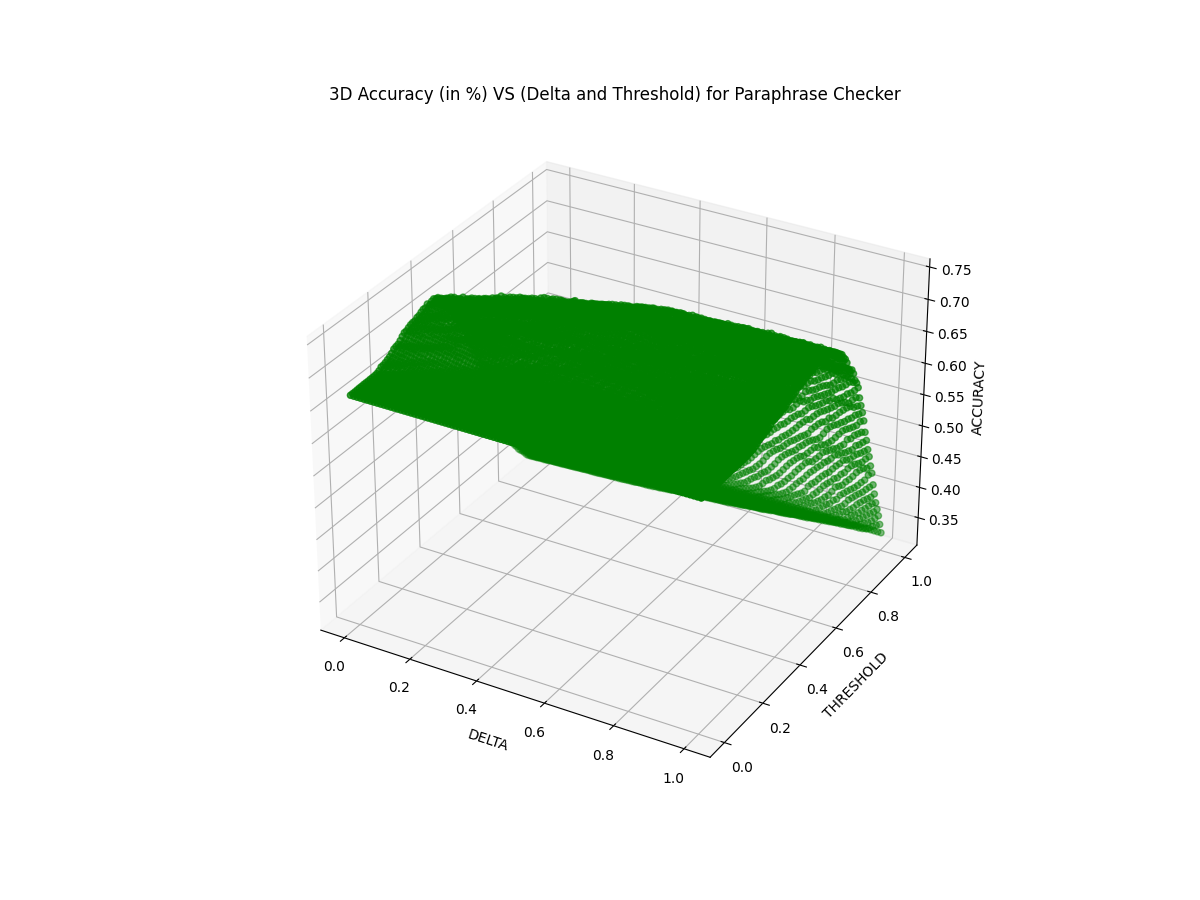

In [190]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
x = []
y = []
z = []
for i in dict_para_2D.keys():
      for j in dict_para_2D[i].keys():
            x.append(i)
            y.append(j)
            z.append(dict_para_2D[i][j])

# Creating figure
fig = plt.figure(figsize = (12, 9))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(x, y, z, color = "green")
ax.set_xlabel('DELTA')
ax.set_ylabel('THRESHOLD')
ax.set_zlabel('ACCURACY')
plt.title("3D Accuracy (in %) VS (Delta and Threshold) for Paraphrase Checker")

# show plot
plt.show()

## ii. Calculating Delta for Semantic Similarity Checker by training through Semantic Similarity Dataset

In [27]:
# pprint.pprint(dataSet_sem)
for i in dataSet_sem:
    i[2] = float(i[2])/float(5)
    if(i[2] == 0):
        i[2] = 0.01

In [28]:
# Algo for calculating the delta
# DataSet is stored as List[list[sen1,sen2, val in range 0-5]]

# Its key value will be value for delta and the value stored against it will be the accuracy
dict_sem = {}
sem_list_sem = []
order_list_sem = []

ct_sem = 0
for i in dataSet_sem:
  sem_list_sem.append(semantic_similarity(i[0],i[1]))
  order_list_sem.append(word_order_similarity(i[0],i[1]))
  print(ct_sem)
  ct_sem += 1
  if(ct_sem == 3000):
    break

DELTA = 0
accuracy_sem = 0
while(DELTA != 1.01):
  # print(DELTA,end = " ")
  if(DELTA >= 1.01):
    break
  for i in range(0,ct_sem):
    accuracy_sem += 1-(abs((sem_list_sem[i] * DELTA) + ((1-DELTA) * order_list_sem[i])-float(dataSet_sem[i][2])))
  accuracy_sem = accuracy_sem/ct_sem
  dict_sem[DELTA] = accuracy_sem
  DELTA = DELTA + 0.01
  # print(accuracy_sem)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Plotting a graph of Accuracy VS Delta for the Similarity Similarity Checker



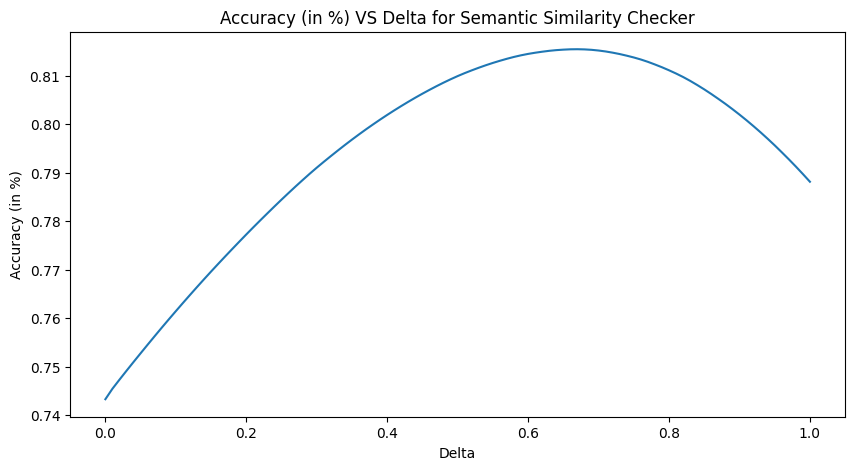

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,5))
plt.xlabel("Delta")
plt.ylabel("Accuracy (in %)")
plt.title("Accuracy (in %) VS Delta for Semantic Similarity Checker")
delta_val = list(dict_sem.keys())
accuracy_val = list(dict_sem.values())
# plt.bar(delta_val, accuracy_val, width=0.7)
plt.plot(delta_val,accuracy_val)
plt.show()

Computing the optimal Delta for Semantic Similarity Checker

In [30]:
temp_DELTA = 0
DELTA_SEM = 0
maxAccuracy_Sem = 0
while(temp_DELTA <= 1):
    if(dict_sem[temp_DELTA] > maxAccuracy_Sem):
        maxAccuracy_Sem = dict_sem[temp_DELTA]
        DELTA_SEM = temp_DELTA
    temp_DELTA += 0.01
print(DELTA_SEM)

0.6700000000000004


## iii. Calculating Delta for Question Similarity Checker by training through Question Similarity Dataset

In [31]:
# Algo for calculating the delta

# DataSet is stored as List[list[sen1,sen2, 0 or 1]]

# Its key value will be value for delta and the value stored against it will be the accuracy
dict_ques = {}
sem_list_ques = []
order_list_ques = []

ct = 0
for i in dataSet_ques:
  sem_list_ques.append(semantic_similarity(i[0],i[1]))
  order_list_ques.append(word_order_similarity(i[0],i[1]))
  # print(ct)
  ct += 1
  if(ct == 3000):
    break


In [32]:
# pprint.pprint(dataSet_ques)

In [33]:
# Trying to make a 3d graph taking 2 variables,
    # OptimumScore and value of DELTA

# Its key value will be value for delta and the value stored against it will be the accuracy
dict_ques_2D = {}

OptimumScore_ques = 0
DELTA = 0
similar_count = 0
while(DELTA != 1.01):
  # print(DELTA,end = " ")
  if(DELTA >= 1.01):
    break
  tempDict = {}
  while OptimumScore_ques != 1.01:
    if(OptimumScore_ques >= 1.01):
      break
    for i in range(0,ct):
      if(((sem_list_ques[i] * DELTA) + ((1-DELTA) * order_list_ques[i])) >= OptimumScore_ques):
        if(dataSet_ques[i][2] == '1'):
          similar_count += 1
      else:
        if(dataSet_ques[i][2] == '0'):
          similar_count += 1
    accuracy_ques = similar_count/ct
    tempDict[OptimumScore_ques] = accuracy_ques
    similar_count = 0
    OptimumScore_ques += 0.01
  dict_ques_2D[DELTA] = tempDict
  DELTA = DELTA + 0.01
  OptimumScore_ques = 0
  similar_count = 0
  # print(len(tempDict))
# print(len(dict_ques_2D))


Computing the optimal Delta for Question Similarity Checker

In [34]:
# Finding the most optimal OptimumScore and Delta pair
accu = 0
OptimumScore_ques = 0
DELTA_QUES = 0
for i in dict_ques_2D.keys():
    for j in dict_ques_2D[i].keys():
        if dict_ques_2D[i][j] > accu:
            accu = dict_ques_2D[i][j]
            OptimumScore_ques = j
            DELTA_QUES = i
print(DELTA_QUES)
print(OptimumScore_ques)

0.7800000000000005
0.7200000000000004


Plotting a graph of Accuracy VS Delta for the Question Similarity Checker

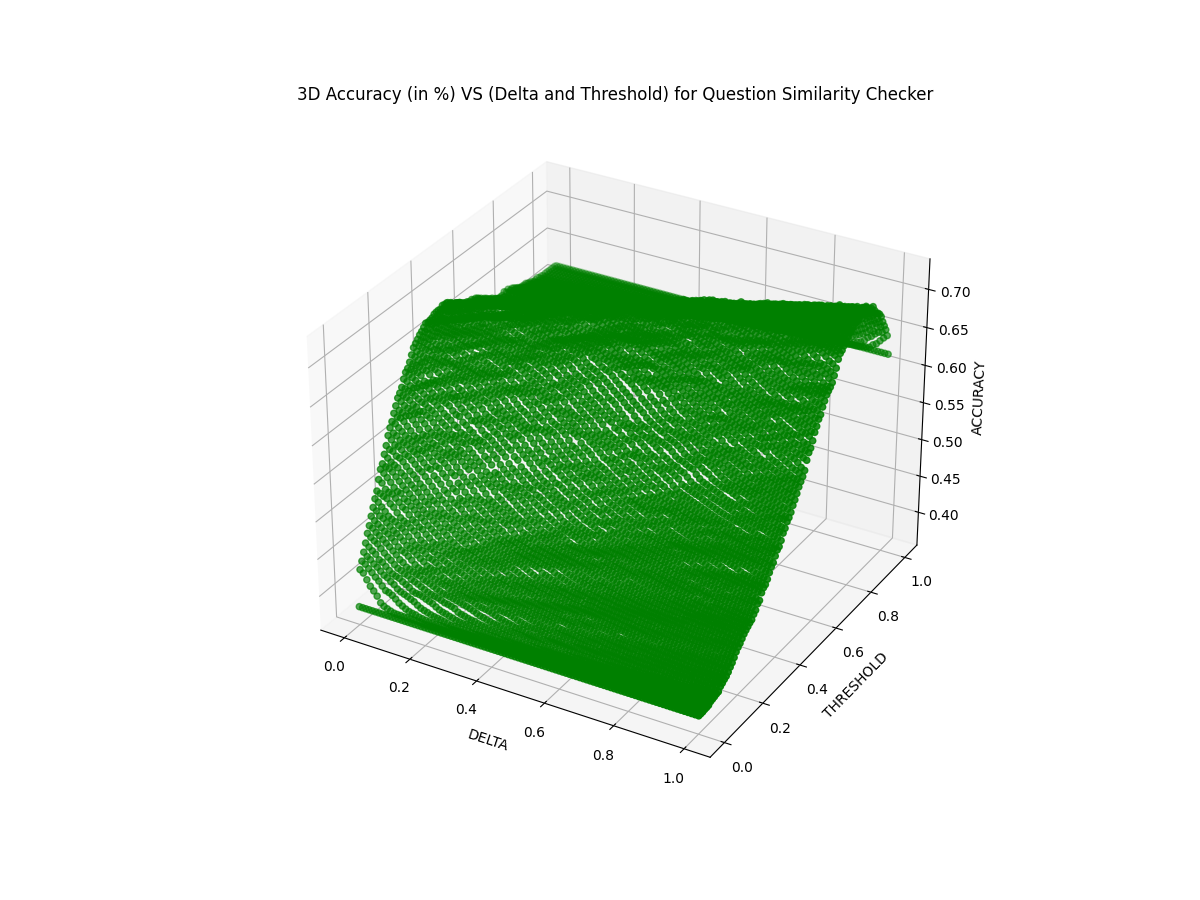

In [181]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

x = []
y = []
z = []
for i in dict_ques_2D.keys():
      for j in dict_ques_2D[i].keys():
            x.append(i)
            y.append(j)
            z.append(dict_ques_2D[i][j])

# Creating figure
fig = plt.figure(figsize = (12, 9))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(x, y, z, color = "green")
ax.set_xlabel('DELTA')
ax.set_ylabel('THRESHOLD')
ax.set_zlabel('ACCURACY')
plt.title("3D Accuracy (in %) VS (Delta and Threshold) for Question Similarity Checker")

# show plot
plt.show()


In [36]:
print(OptimumScore_para)
print(OptimumScore_ques)
print(DELTA_PARA)
print(DELTA_SEM)
print(DELTA_QUES)

0.5100000000000002
0.7200000000000004
0.35000000000000014
0.6700000000000004
0.7800000000000005




---



## 7. Testing the accuracy of the model on some predefined Dataset.

In [37]:
# Taking data that was left out for training and checking the accuracy we are getting
Testing_DataSet_sem = []
Testing_DataSet_para = []
Testing_DataSet_ques = []

for i in range(4001,7501):
    Testing_DataSet_para.append(dataSet_para[i])
for i in range(4001,7501):
    Testing_DataSet_sem.append(dataSet_sem[i])
for i in range(4001,7501):
    Testing_DataSet_ques.append(dataSet_ques[i])

# print(Testing_DataSet_para)

In [38]:
# Para phrase checker Accuracy graph 
similar_count = 0
for i in range(0,3000):
  if(((semantic_similarity(Testing_DataSet_para[i][0],Testing_DataSet_para[i][1]) * DELTA_PARA) + ((1-DELTA_PARA) * word_order_similarity(Testing_DataSet_para[i][0],Testing_DataSet_para[i][1]))) >= OptimumScore_para):
    if(Testing_DataSet_para[i][2] == '1'):
      similar_count += 1
  else:
    if(Testing_DataSet_para[i][2] == '0'):
      similar_count += 1
accuracy_para = similar_count/3000
print(accuracy_para)

0.7226666666666667


In [39]:
# Sem similarity accuracy graph
accuracy_sem = 0
for i in range(0,3000):
    accuracy_sem += 1-(abs((semantic_similarity(Testing_DataSet_sem[i][0],Testing_DataSet_sem[i][1]) * DELTA_SEM) + ((1-DELTA_SEM) * word_order_similarity(Testing_DataSet_sem[i][0],Testing_DataSet_sem[i][1]))-float(dataSet_sem[i][2])))
accuracy_sem = accuracy_sem/3000
print(accuracy_sem)

0.6860624380896544


In [40]:
# Ques Similarity accuracy graph
similar_count = 0
for i in range(0,3000):
  if(((semantic_similarity(Testing_DataSet_ques[i][0],Testing_DataSet_ques[i][1]) * DELTA_QUES) + ((1-DELTA_QUES) * word_order_similarity(Testing_DataSet_ques[i][0],Testing_DataSet_ques[i][1]))) >= OptimumScore_ques):
    if(Testing_DataSet_ques[i][2] == '1'):
      similar_count += 1
  else:
    if(Testing_DataSet_ques[i][2] == '0'):
      similar_count += 1
accuracy_ques = similar_count/3000
print(accuracy_ques)

0.6996666666666667




---



# Testing the Program

### Sentence 1 = "i am studying for the exam"
### Sentence 2 = "i am playing for fun" 

In [41]:
SampleSen1 = 'i am studying for the exam'
SampleSen2 = 'i am playing for fun'

SampleJointSet = joint_set(SampleSen1,SampleSen2)

SampleSemVec1 = semantic_vector(word_tokenize(SampleSen1),SampleJointSet)
SampleSemVec2 = semantic_vector(word_tokenize(SampleSen2),SampleJointSet)

SampleOrderVec1 = wordOrder_vector(word_tokenize(SampleSen1),SampleJointSet)
SampleOrderVec2 = wordOrder_vector(word_tokenize(SampleSen2),SampleJointSet)

print("Joint Set = " ,end="")
for i in SampleJointSet:
  print(i , end=" ")
print("")

print("Semantic Vector for Sen1 = " ,end="")
for i in SampleSemVec1:
  print(i , end = "  ")
print("")

print("Semantic Vector for Sen2 = " ,end="")
for i in SampleSemVec2:
  print(i , end = "  ")
print("")

print("Order Vector for Sen1 = " ,end="")
for i in SampleOrderVec1:
  print(i , end = "  ")
print("")

print("Order Vector for Sen2 = " ,end="")
for i in SampleOrderVec2:
  print(i , end = "  ")
print("")

print(similarity(SampleSen1,SampleSen2))

Joint Set = i am studying for the exam playing fun 
Semantic Vector for Sen1 = 0.15037146799075982  0.3698375655146025  0.5388723628142813  0.11848477504571897  0.04046295427858762  1.0  0.08645060283367294  0.0  
Semantic Vector for Sen2 = 0.15037146799075982  0.3698375655146025  0.09488649842840469  0.11848477504571897  0.0  0.0  0.4473146499898666  0.5291300526271261  
Order Vector for Sen1 = 1  2  3  4  5  6  0  0  
Order Vector for Sen2 = 1  2  0  4  0  0  3  5  
0.26657671724180465


In [68]:
# ParaPhrase Checker
DELTA = 0.35
Threshold = 0.51

In [43]:
SampleSen1 = 'What is the time?'
SampleSen2 = 'I am the president of India.'
if(similarity(SampleSen1,SampleSen2) >= Threshold):
    print("YES, They are Paraphrase")
else:
    print("No, They are not Paraphrase")

No, They are not Paraphrase


In [70]:
SampleSen1 = 'Giraffes like Acacia leaves and hay and they can consume 75 pounds of food a day.'
SampleSen2 = 'A giraffe can eat up to 75 pounds of Acacia leaves and hay every day.'
if(similarity(SampleSen1,SampleSen2) >= Threshold):
    print("YES, They are Paraphrase")
else:
    print("No, They are not Paraphrase")

YES, They are Paraphrase


In [93]:
# Question Similarity
DELTA = 0.78
ThresHold = 0.72

In [89]:
SampleSen1 = 'What is the time?'
SampleSen2 = 'What is your name?'
if(similarity(SampleSen1,SampleSen2) >= Threshold):
    print("YES, They are the same Question")
else:
    print("No, They are not the same Question")

No, They are not the same Question


In [97]:
SampleSen1 = 'What is the best/most memorable thing you have ever eaten and why?'
SampleSen2 = 'What is the most delicious dish you have ever eaten and why?'
if(similarity(SampleSen1,SampleSen2) >= Threshold):
    print("YES, They are the same Question")
else:
    print("No, They are not the same Question")

YES, They are the same Question


In [74]:
# Semantic Similarity
DELTA = 0.67

In [81]:
SampleSen1 = 'John killed Bill.'
SampleSen2 = 'John killed Bill.'
print(similarity(SampleSen1,SampleSen2))

1.0


In [84]:
SampleSen1 = 'John killed Bill.'
SampleSen2 = 'Bill killed John.'
print(similarity(SampleSen1,SampleSen2))

0.8652780641469252


In [85]:
SampleSen1 = 'John killed Bill with poison.'
SampleSen2 = 'John killed Bill with a gun.'
print(similarity(SampleSen1,SampleSen2))

0.6096417427634295


In [86]:
SampleSen1 = 'John killed Bill with poison.'
SampleSen2 = 'Bill killed John with a gun.'
print(similarity(SampleSen1,SampleSen2))

0.5847057186410874


In [87]:
SampleSen1 = 'John killed Bill with a rifle.'
SampleSen2 = 'John killed Bill with a gun.'
print(similarity(SampleSen1,SampleSen2))

0.8078426987761698
